In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from matplotlib import pyplot
import matplotlib.pyplot as plt

### Load the CIFAR-10 Dataset

In [2]:
# How many images to load per batch 
batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# training data loaded onto GPU
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# test data loaded onto GPU
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### Display sample images

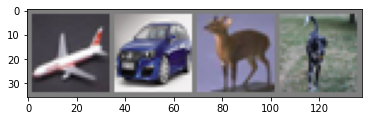

plane car   deer  dog  
torch.Size([4])


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(labels.shape)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) 

cuda:0


### Old Network
This is the first network that I created. It has two convolutional layers with batch normalization and dropout to increase the robustness of the model. However, when I ran the training process with this configuration, I averaged around 64% accuracy which was less than ideal. 

In [5]:
# Old network 
import torch.nn as nn
import torch.nn.functional as F


class NetOld(nn.Module):
    
    def __init__(self, activation):
        super().__init__()

        self.layer1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
            
        self.layer2 =  nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1)
        
        self.activation = activation
        
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        
        # Define dropout layers
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(1280, 100)
        self.fc2 = nn.Linear(100, 10)
        
    
    def forward(self,x):

        x = F.max_pool2d(self.activation(self.bn1(self.layer1(x))), 2)
        x = self.dropout1(x)
        
        x = F.max_pool2d(self.activation(self.bn2(self.layer2(x))), 2)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

    

### New Network
To address the low accuracy scores from before, I decided to increase the complexity of the network by adding another convolutional layer in order to extract additional features from my images. 

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self, activation):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.layer3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.activation = activation
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(4 * 4 * 128, 512)  # Adjust according to the output size after convolutional layers
        self.fc2 = nn.Linear(512, 10)

        
    
    def forward(self,x):
        x = F.max_pool2d(self.activation(self.bn1(self.layer1(x))), 2)
        x = self.dropout1(x)
        
        x = F.max_pool2d(self.activation(self.bn2(self.layer2(x))), 2)
        x = self.dropout2(x)
        
        x = F.max_pool2d(self.activation(self.bn3(self.layer3(x))), 2)
        x = self.dropout3(x)
        
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return x

    

## Training Process
I created a function to execute the training pipeline over 10 epochs. I added a few arguments to enable some simple hyperparameter tuning for the type of model and the loss function. 

In [7]:
# Train the network and print accuracy and loss overtime
# From https://www.kaggle.com/code/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap#Convolution-Layer
print_freq = 100  # Print frequency.

def fit(train_dl, model, loss, optim, epochs=10):
    
    accuracy_overtime = []
    loss_overtime = []
    
    for epoch in range(epochs):
        
        avg_loss = 0
        correct = 0
        total=0

        for i, data in enumerate(train_dl,0): # Iterate over Data Loder
    
            # Forward pass
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optim.zero_grad()
            
            # get predictions
            outputs = model(inputs) 
            
            # calculate loss
            L = loss(outputs, labels)
            avg_loss += L.item()
            
            total += outputs.size(0)
            
            # Backward pass
            L.backward()
            optim.step()
            
            # Metrics
            _, original =  torch.max(labels, 0)
            _, predicted = torch.max(outputs.data, 1)
            correct = correct + (original == predicted).sum().item()
                    
        # Update metrics
        accuracy_overtime.append(correct/total)
        loss_overtime.append(avg_loss/len(train_dl))
                
    return accuracy_overtime, loss_overtime

In [8]:
def plot_accuracy_loss(accuracy, loss):
    f = pyplot.figure(figsize=(15,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.title.set_text("Accuracy over epochs")
    ax2.title.set_text("Loss over epochs")
    ax1.plot(accuracy)
    ax2.plot(loss, 'r:')

In [9]:
 def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


### Initial models
I initialized three models as a baseline measure to see how well this new network was performing. net1 uses a ReLU activation function, whereas net2 and net3 utilize sigmoid and tanh respectively for their activations.

In [10]:
def print_accuracies(model):
    # Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

    # Get test accuracy for each class.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [11]:
# Define your models, datasets, and dataloaders
epochs = 10
net1 = Net(F.relu)   # Create the network1 instance.
net1.to(device)         # Move the network parameters to the specified device.
net1.apply(init_weights)
optim1 = optim.SGD(net1.parameters(),lr = 0.001,  momentum = 0.9)
loss1 = nn.CrossEntropyLoss()

net2 = Net(F.sigmoid)   # Create the network2 instance.
net2.to(device)         # Move the network parameters to the specified device.
net2.apply(init_weights)
optim2 = optim.SGD(net2.parameters(), lr=0.001)
loss2 = nn.CrossEntropyLoss()

net3 = Net(F.tanh)   # Create the network3 instance.
net3.to(device)         # Move the network parameters to the specified device.
net3.apply(init_weights)
optim3 = optim.SGD(net3.parameters(), lr=0.001)
loss3 = nn.CrossEntropyLoss()


In [12]:
output1 = fit(trainloader, net1, loss1, optim1, epochs)

In [13]:
output2 = fit(trainloader, net2, loss2, optim2, epochs)

In [14]:
output3 = fit(trainloader, net3, loss3, optim3, epochs)

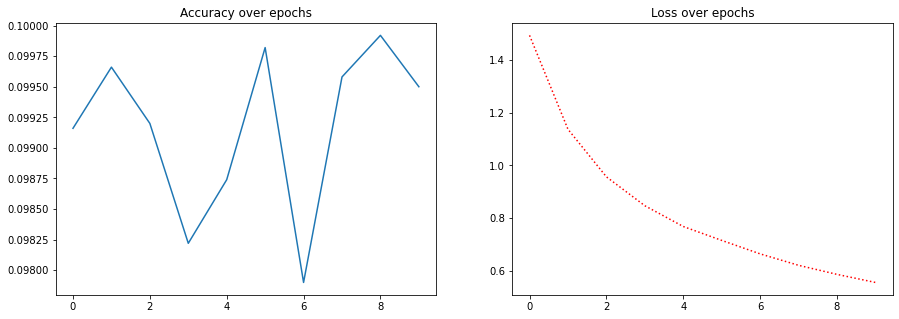

In [15]:
plot_accuracy_loss(*output1)

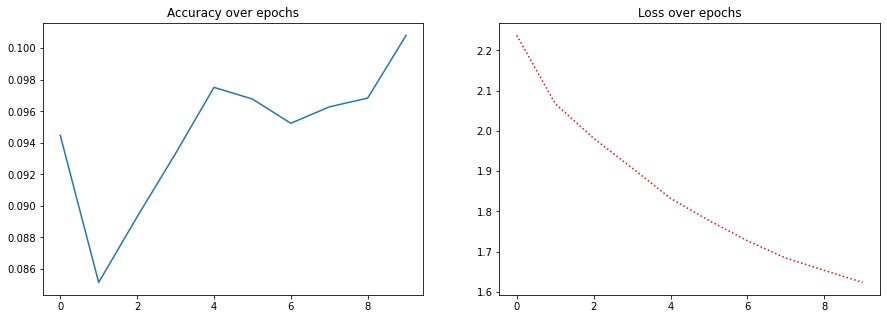

In [16]:
plot_accuracy_loss(*output2)

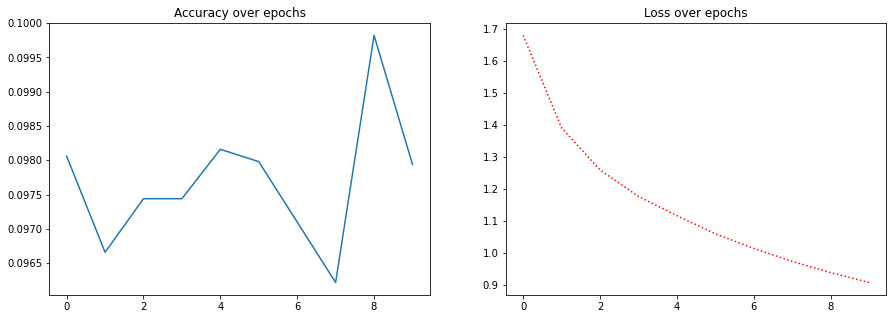

In [17]:
plot_accuracy_loss(*output3)

In [18]:
print_accuracies(net1)

Accuracy of the network on the 10000 test images: 74 %
Accuracy of plane : 78 %
Accuracy of   car : 79 %
Accuracy of  bird : 59 %
Accuracy of   cat : 65 %
Accuracy of  deer : 74 %
Accuracy of   dog : 52 %
Accuracy of  frog : 82 %
Accuracy of horse : 83 %
Accuracy of  ship : 89 %
Accuracy of truck : 82 %


In [19]:
print_accuracies(net2)

Accuracy of the network on the 10000 test images: 41 %
Accuracy of plane : 34 %
Accuracy of   car : 63 %
Accuracy of  bird : 25 %
Accuracy of   cat : 18 %
Accuracy of  deer : 34 %
Accuracy of   dog : 46 %
Accuracy of  frog : 39 %
Accuracy of horse : 45 %
Accuracy of  ship : 64 %
Accuracy of truck : 47 %


In [20]:
print_accuracies(net3)

Accuracy of the network on the 10000 test images: 66 %
Accuracy of plane : 72 %
Accuracy of   car : 76 %
Accuracy of  bird : 51 %
Accuracy of   cat : 47 %
Accuracy of  deer : 60 %
Accuracy of   dog : 52 %
Accuracy of  frog : 77 %
Accuracy of horse : 74 %
Accuracy of  ship : 80 %
Accuracy of truck : 72 %


In [21]:
# For comparison, let's run the old network to see how well the new network performs
net_old = NetOld(F.relu)   # Create the network1 instance.
net_old.to(device)         # Move the network parameters to the specified device.
net_old.apply(init_weights)
optim_old = optim.SGD(net_old.parameters(),lr = 0.001,  momentum = 0.9)
loss_old = nn.CrossEntropyLoss()

output_old = fit(trainloader, net_old, loss_old, optim_old, epochs)


In [22]:
print_accuracies(net_old)

Accuracy of the network on the 10000 test images: 63 %
Accuracy of plane : 68 %
Accuracy of   car : 78 %
Accuracy of  bird : 51 %
Accuracy of   cat : 44 %
Accuracy of  deer : 43 %
Accuracy of   dog : 58 %
Accuracy of  frog : 73 %
Accuracy of horse : 66 %
Accuracy of  ship : 79 %
Accuracy of truck : 71 %


### Results of current models

At this point, it seems that we generally see improved results on classes like dog, frog, and and ship compared to our old network. However, net1 performs the best out of all the current configurations of the parameters. ReLU and SGD seems to work very nicely. We'll perform further hyperparameter tuning (while keeping ReLU and SGD the same) to see if we can increase our accuracy. Let's try increasing the layer one more time and let's introduce different pooling methods to see what will happen.

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class NetOptimized(nn.Module):
    
    def __init__(self, activation, pooling_function='max'):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.layer3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.layer4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.activation = activation
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.2)
        self.dropout4 = nn.Dropout(p=0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = self.fc1 = nn.Linear(1024, 512) # Adjust according to the output size after convolutional layers
        self.fc2 = nn.Linear(512, 10)
        
        if pooling_function == 'max':
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pooling_function == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling_function == 'frac':
            self.pool = nn.FractionalMaxPool2d(kernel_size=2, output_ratio=(1/2, 1/2))  # Output ratio for 2x downsampling
        elif pooling_function == 'adapt':
            self.pool = nn.AdaptiveMaxPool2d((2, 2))  # Adjust output size as needed

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.layer1(x))))
        x = self.dropout1(x)

        x = self.pool(self.activation(self.bn2(self.layer2(x))))
        x = self.dropout2(x)

        x = self.pool(self.activation(self.bn3(self.layer3(x))))
        x = self.dropout3(x)

        x = self.pool(self.activation(self.bn4(self.layer4(x))))
        x = self.dropout4(x)

        # Update the output size of the last pooling layer
        self.pool_output_size = x.size()[1:]

        x = self.flatten(x)

        # Adjust the input size for fc1 based on the output size of the last pooling layer
        fc1_input_size = self.pool_output_size[0] * self.pool_output_size[1] * self.pool_output_size[2]

        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return x
   


In [24]:
net4 = NetOptimized(F.relu, 'avg')   # Create the network1 instance.
net4.to(device)         # Move the network parameters to the specified device.
net4.apply(init_weights)
optim4 = optim.SGD(net4.parameters(),lr = 0.001,  momentum = 0.9)
loss4 = nn.CrossEntropyLoss()


net5 = NetOptimized(F.relu, 'frac')   # Create the network1 instance.
net5.to(device)         # Move the network parameters to the specified device.
net5.apply(init_weights)
optim5 = optim.SGD(net5.parameters(),lr = 0.001,  momentum = 0.9)
loss5 = nn.CrossEntropyLoss()

net6 = NetOptimized(F.relu, 'adapt')   # Create the network1 instance.
net6.to(device)         # Move the network parameters to the specified device.
net6.apply(init_weights)
optim6 = optim.SGD(net6.parameters(),lr = 0.001,  momentum = 0.9)
loss6 = nn.CrossEntropyLoss()

In [25]:
output4 = fit(trainloader, net4, loss4, optim4, epochs)

In [26]:
print_accuracies(net4)

Accuracy of the network on the 10000 test images: 74 %
Accuracy of plane : 75 %
Accuracy of   car : 84 %
Accuracy of  bird : 61 %
Accuracy of   cat : 57 %
Accuracy of  deer : 71 %
Accuracy of   dog : 64 %
Accuracy of  frog : 82 %
Accuracy of horse : 79 %
Accuracy of  ship : 91 %
Accuracy of truck : 81 %


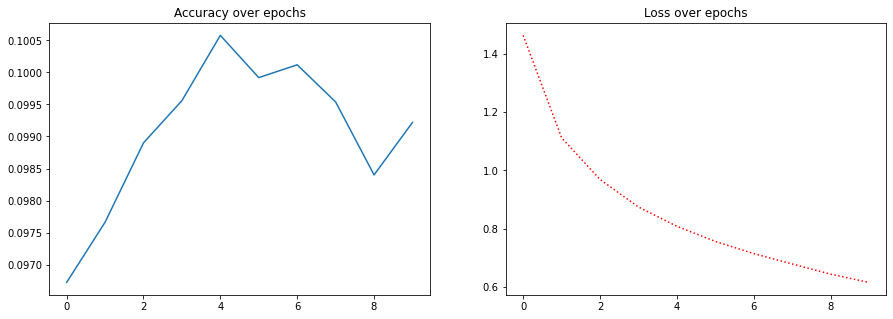

In [27]:
plot_accuracy_loss(*output4)

In [28]:
output5 = fit(trainloader, net5, loss5, optim5, epochs)

In [29]:
print_accuracies(net5)

Accuracy of the network on the 10000 test images: 73 %
Accuracy of plane : 73 %
Accuracy of   car : 87 %
Accuracy of  bird : 61 %
Accuracy of   cat : 64 %
Accuracy of  deer : 68 %
Accuracy of   dog : 54 %
Accuracy of  frog : 77 %
Accuracy of horse : 80 %
Accuracy of  ship : 78 %
Accuracy of truck : 85 %


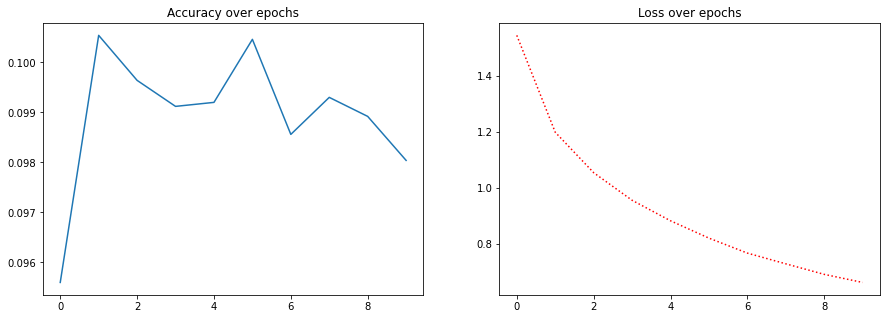

In [30]:
plot_accuracy_loss(*output5)

In [31]:
output6 = fit(trainloader, net6, loss6, optim6, epochs)

In [32]:
print_accuracies(net6)

Accuracy of the network on the 10000 test images: 43 %
Accuracy of plane : 53 %
Accuracy of   car : 63 %
Accuracy of  bird : 26 %
Accuracy of   cat : 28 %
Accuracy of  deer : 24 %
Accuracy of   dog : 22 %
Accuracy of  frog : 58 %
Accuracy of horse : 55 %
Accuracy of  ship : 53 %
Accuracy of truck : 36 %


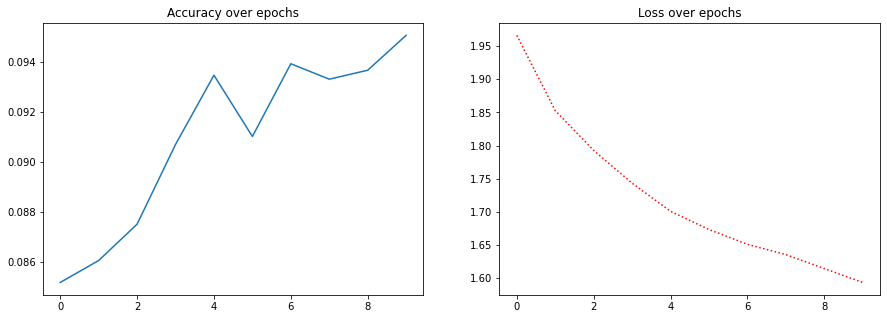

In [33]:
plot_accuracy_loss(*output6)

## Discussion of results and Further Comparisons
After running tests with the various types of pooling functions, it seems that average pooling just does as good as the default max pooling from before, achieving an accuracy of 75%. However, we seek to choose the simplest model so we'll go with net1 from before. But how well does this compare to industry standard convolutional neural networks like Resnet18?

### Training Alexnet on Cifar-10

In [34]:
from torchvision.models import resnet18

In [35]:
model = resnet18(pretrained=False)  # Not using pre-trained weights
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Change the last fully connected layer for 10 classes
model.to(device)

num_epochs = 10
learning_rate = 0.001
batch_size = 128



# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(trainloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.9270
Epoch [2/10], Loss: 1.4963
Epoch [3/10], Loss: 1.2707
Epoch [4/10], Loss: 1.1167
Epoch [5/10], Loss: 1.0003
Epoch [6/10], Loss: 0.9036
Epoch [7/10], Loss: 0.8229
Epoch [8/10], Loss: 0.7515
Epoch [9/10], Loss: 0.6803
Epoch [10/10], Loss: 0.6235


In [36]:
# Evaluation
print_accuracies(model)

Accuracy of the network on the 10000 test images: 70 %
Accuracy of plane : 80 %
Accuracy of   car : 81 %
Accuracy of  bird : 62 %
Accuracy of   cat : 61 %
Accuracy of  deer : 69 %
Accuracy of   dog : 47 %
Accuracy of  frog : 80 %
Accuracy of horse : 70 %
Accuracy of  ship : 73 %
Accuracy of truck : 81 %


After having trained ResNet18 on the Cifar10 dataset, the results are not that suprising with the accuracy coming very close to our previous results, falling short by a margin of around 3%. Resnet18 was initially designed and trained on samples from the ImageNet dataset, so its architectural choices for pooling and dimensionality reduction don't necessarily scale well in the context of smaller inputs like CIFAR10. 